In [175]:
import numpy as np
import scipy
from scipy.io import wavfile
import matplotlib.pyplot as plt
from lib import  hann, fft, fft_v, dct
import librosa

In [176]:
PATH = 'AudioData/'
sr, audio = wavfile.read(PATH + "Output_4.wav")
print("Sample rate: {0}Hz".format(sr))
print("Audio duration: {0}s".format(len(audio) / sr))
print(type(audio))

Sample rate: 44100Hz
Audio duration: 2.0s
<class 'numpy.ndarray'>


In [177]:
def normalize_audio(audio):
    audio = audio / np.max(np.abs(audio))
    return audio

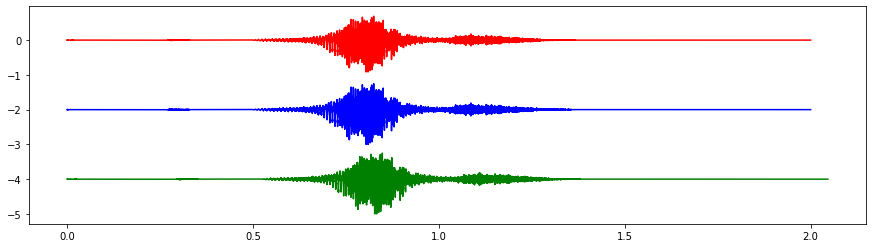

In [178]:
norm_audio = normalize_audio(audio)
final_audio = np.pad(norm_audio, int(2048 / 2), mode='reflect')

plt.figure(figsize=(15,4))
plt.plot(np.linspace(0, len(audio) / sr, num=len(audio)), audio, "r")
plt.plot(np.linspace(0, len(norm_audio) / sr, num=len(norm_audio)), norm_audio-2, "b")
plt.plot(np.linspace(0, len(final_audio) / sr, num=len(final_audio)), final_audio-4, "g")
plt.show()

In [179]:
def frame_audio(audio, Frame_size=1024, hop_size=10, sample_rate=44100):
    # hop_size in ms
    
    audio = np.pad(audio, int(Frame_size / 2), mode='reflect')
    print(audio.shape)
    hop_len = np.round(sample_rate * hop_size / 1000).astype(int)
    frame_num = int((len(audio) - Frame_size) / hop_len) + 1
    frames = np.zeros((frame_num,Frame_size))
    
    for n in range(frame_num):
        frames[n] = audio[n*hop_len:n*hop_len+Frame_size]
    
    return frames

In [180]:
def my_frame_audio(audio, Frame_size=1024, hop_size=10, sample_rate=44100):
    hop_len = np.round(sample_rate * hop_size / 1000).astype(int)
    print("hop_len:", hop_len)
    frame_num = int((len(audio) - Frame_size) / hop_len)
    print(frame_num)
    frames = np.zeros((frame_num,Frame_size))
    
    for n in range(frame_num):
        frames[n] = audio[n*hop_len:n*hop_len+Frame_size]
    
    return frames

In [181]:
frames = frame_audio(norm_audio)
my_frames = my_frame_audio(norm_audio)
print(frames.shape)
print(my_frames.shape)

(89224,)
hop_len: 441
197
(201, 1024)
(197, 1024)


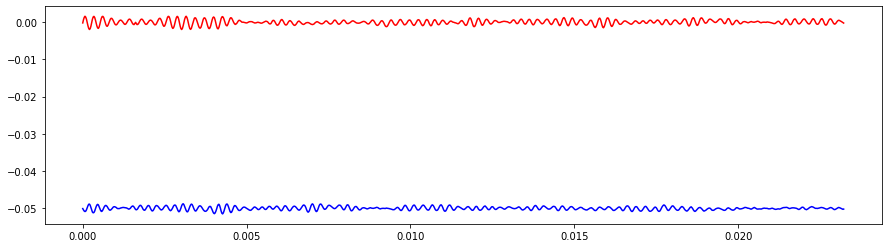

In [182]:
plt.figure(figsize=(15,4))
plt.plot(np.linspace(0, len(frames[1]) / sr, num=len(frames[1])), frames[1], "r")
plt.plot(np.linspace(0, len(my_frames[1]) / sr, num=len(my_frames[1])), my_frames[1]-0.05, "b")
plt.show()

In [183]:
window = hann()
print(window.size)
Frame_size = 1024

1024


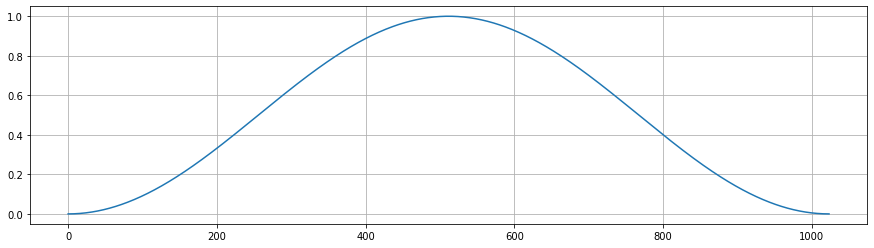

In [184]:
plt.figure(figsize=(15,4))
plt.plot(window)
plt.grid(True)

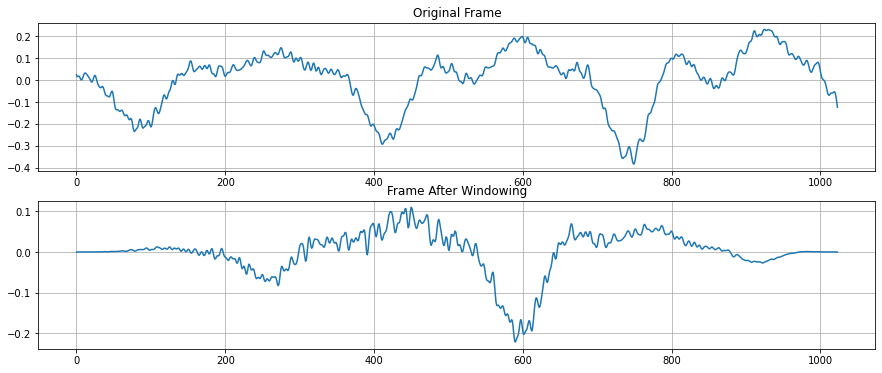

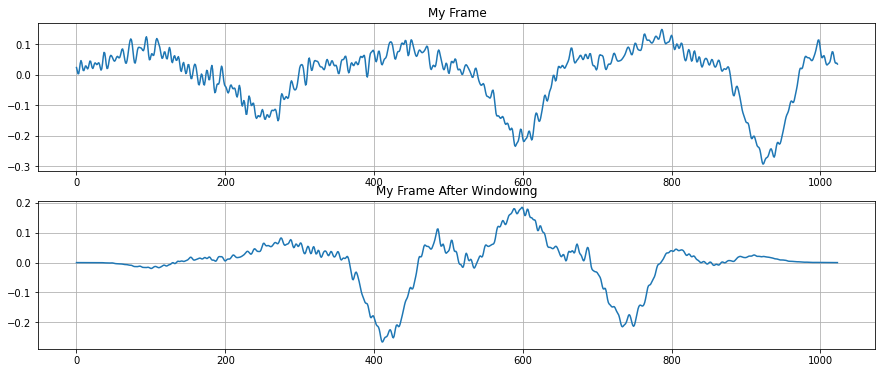

In [185]:
audio_win2 = my_frames * window
audio_win1 = frames * window

ind = 69
plt.figure(figsize=(15,6))
plt.subplot(2, 1, 1)
plt.plot(my_frames[ind])
plt.title('Original Frame')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(audio_win1[ind])
plt.title('Frame After Windowing')
plt.grid(True)

plt.figure(figsize=(15,6))
plt.subplot(2, 1, 1)
plt.plot(frames[ind])
plt.title('My Frame')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(audio_win2[ind])
plt.title('My Frame After Windowing')
plt.grid(True)

In [186]:
audio_win1.shape

(201, 1024)

In [187]:
audio_winT = np.transpose(audio_win1)

audio_fft = np.empty((int(1 + Frame_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')
print("empty:", audio_fft.shape)
for n in range(audio_fft.shape[1]):
    audio_fft[:, n] = fft_v(audio_winT[:, n])[:audio_fft.shape[0]]
audio_fft = np.transpose(audio_fft)
print("Final:", audio_fft.shape)

empty: (513, 201)
Final: (201, 513)


In [188]:
audio_power = np.square(np.abs(audio_fft))
print(int(audio_power.max()))
print(int(audio_fft.max()))

17061
89


C:\Users\sakoy\AppData\Local\Temp\ipykernel_19336\1490070038.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  print(int(audio_fft.max()))


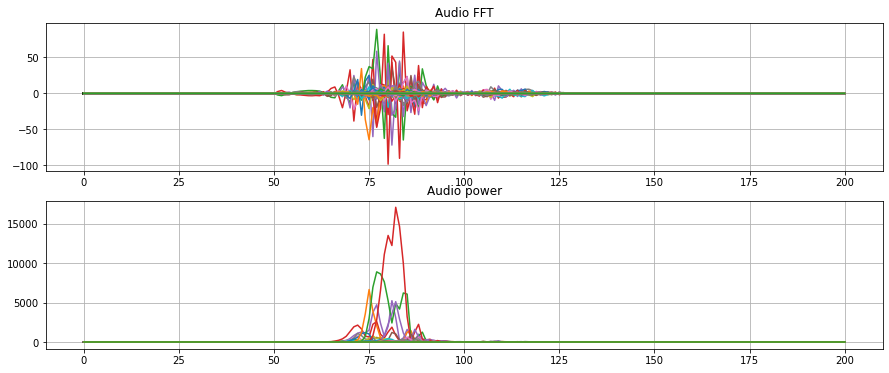

In [189]:
plt.figure(figsize=(15,6))
plt.subplot(2, 1, 1)
plt.plot(audio_fft)
plt.title('Audio FFT')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(audio_power)
plt.title('Audio power')
plt.grid(True)

In [190]:
freq_min = 0
freq_max = sr / 2
mel_filter_num = 40

print("Minimum frequency: {0}".format(freq_min))
print("Maximum frequency: {0}".format(freq_max))

Minimum frequency: 0
Maximum frequency: 22050.0


In [191]:
def freq_to_mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)

def mel_to_freq(mels):
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)

In [192]:
def get_filter_points(fmin, fmax, mel_filter_num, Frame_size, sample_rate=44100):
    fmin_mel = freq_to_mel(fmin)
    fmax_mel = freq_to_mel(fmax)
    
    print("MEL min: {0}".format(fmin_mel))
    print("MEL max: {0}".format(fmax_mel))
    
    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
    print("mels:", mels)
    freqs = mel_to_freq(mels)
    print("freqs:", freqs)

    
    return np.floor((Frame_size + 1) / sample_rate * freqs).astype(int), freqs

In [193]:
filter_points, mel_freqs = get_filter_points(freq_min, freq_max, mel_filter_num, Frame_size, sample_rate=sr)
filter_points

MEL min: 0.0
MEL max: 3923.337321740179
mels: [   0.           95.69115419  191.38230838  287.07346257  382.76461676
  478.45577094  574.14692513  669.83807932  765.52923351  861.2203877
  956.91154189 1052.60269608 1148.29385027 1243.98500445 1339.67615864
 1435.36731283 1531.05846702 1626.74962121 1722.4407754  1818.13192959
 1913.82308378 2009.51423796 2105.20539215 2200.89654634 2296.58770053
 2392.27885472 2487.97000891 2583.6611631  2679.35231729 2775.04347147
 2870.73462566 2966.42577985 3062.11693404 3157.80808823 3253.49924242
 3349.19039661 3444.8815508  3540.57270499 3636.26385917 3731.95501336
 3827.64616755 3923.33732174]
freqs: [    0.            62.03206123   129.56123192   203.07465067
   283.102625     370.22245675   465.0626067    568.30722807
   680.70110182   803.05500937   936.25158133  1081.25166459
  1239.10125362  1410.93903604  1598.00460681  1801.64741034
  2023.3364751   2264.67101077  2527.39194458  2813.39447989
  3124.74176774  3463.67978992  3832.65356087

array([  0,   1,   3,   4,   6,   8,  10,  13,  15,  18,  21,  25,  28,
        32,  37,  41,  47,  52,  58,  65,  72,  80,  89,  98, 108, 119,
       131, 144, 159, 174, 191, 209, 229, 251, 275, 301, 329, 360, 393,
       429, 469, 512])

In [194]:
def get_filters(filter_points, Frame_size):
    filters = np.zeros((len(filter_points)-2,int(Frame_size/2+1)))
    
    for n in range(len(filter_points)-2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
    
    return filters

(40, 513)


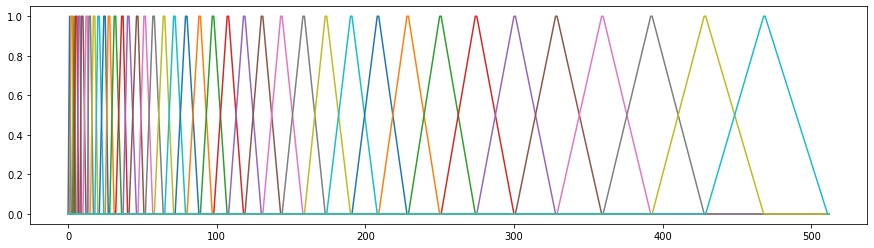

In [195]:
filters = get_filters(filter_points, Frame_size)

plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])
print(filters.shape)

(40,)
(40, 1)


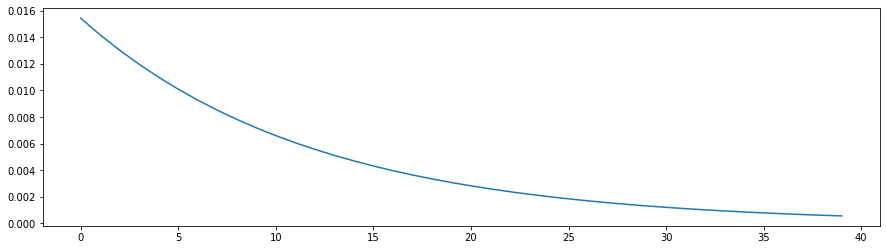

In [196]:
# taken from the librosa library
enorm = 2.0 / (mel_freqs[2:mel_filter_num+2] - mel_freqs[:mel_filter_num])
plt.figure(figsize=(15,4))
plt.plot(enorm)
print(enorm.shape)
print(enorm[:, np.newaxis].shape)
filters *= enorm[:, np.newaxis]

(40, 513)


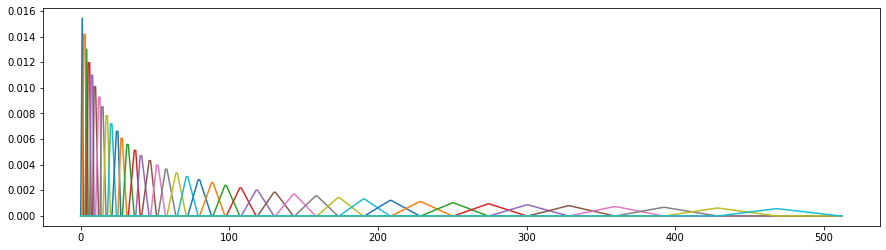

In [197]:
plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])
print(filters.shape)

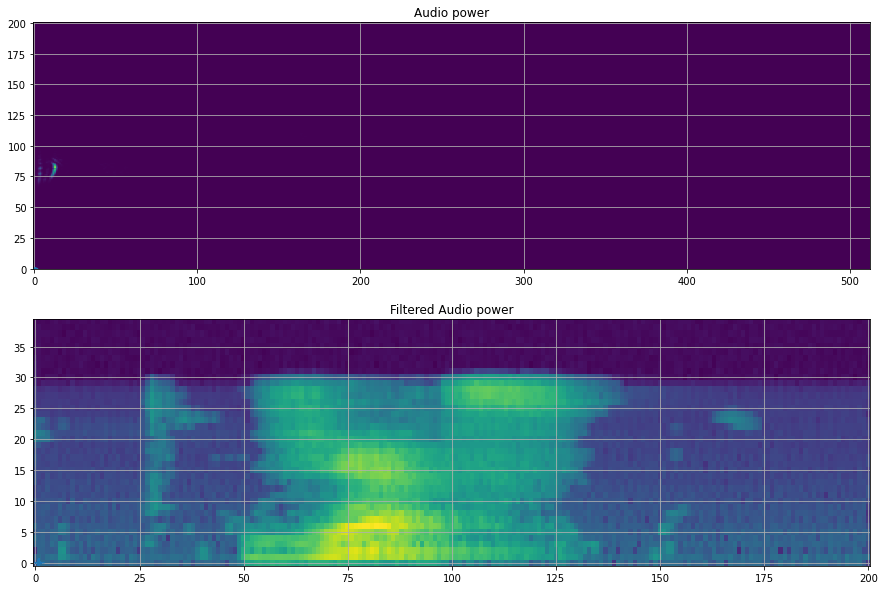

In [198]:
audio_filtered = np.dot(filters, np.transpose(audio_power))
audio_log = 10.0 * np.log10(audio_filtered)
audio_log.shape

plt.figure(figsize=(15,10))

plt.subplot(2, 1, 1)
plt.plot(np.linspace(0, len(audio) / sr, num=len(audio)), audio)
plt.imshow(audio_power, aspect='auto', origin='lower')
plt.title('Audio power')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(np.linspace(0, len(audio) / sr, num=len(audio)), audio)
plt.imshow(audio_log, aspect='auto', origin='lower')
plt.title('Filtered Audio power')
plt.grid(True)

In [199]:
dct_filter_num = 20

dct_filters = dct(dct_filter_num, mel_filter_num)

cepstral_coefficents = np.dot(dct_filters, audio_log)
audio_log.shape



(40, 201)

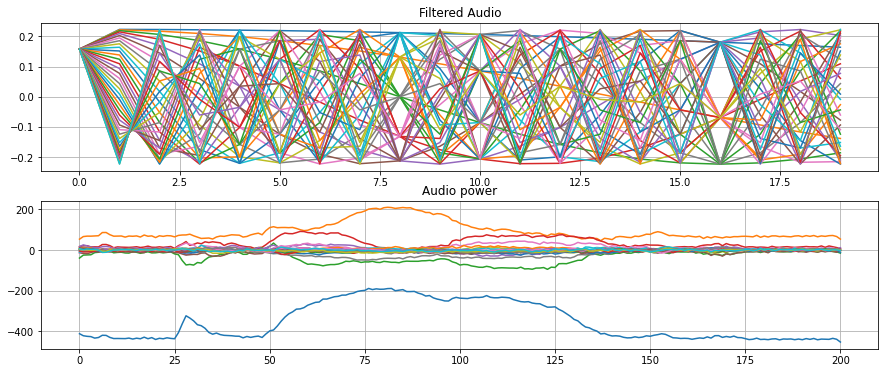

In [200]:
plt.figure(figsize=(15,6))
plt.subplot(2, 1, 1)
plt.plot(dct_filters)
plt.title('Filtered Audio')
plt.grid(True)
plt.subplot(2, 1, 2)
for n in range(cepstral_coefficents.shape[0]):
    plt.plot(cepstral_coefficents[n])

plt.title('Audio power')
plt.grid(True)

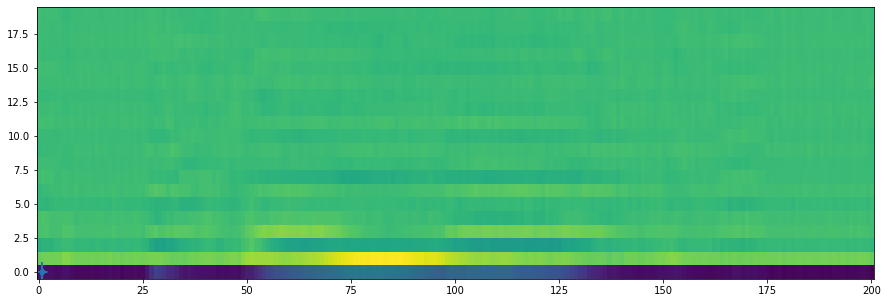

In [201]:
plt.figure(figsize=(15,5))
plt.plot(np.linspace(0, len(audio) / sr, num=len(audio)), audio)
plt.imshow(cepstral_coefficents, aspect='auto', origin='lower');

In [202]:
print(cepstral_coefficents.shape, audio_log.shape)

(20, 201) (40, 201)


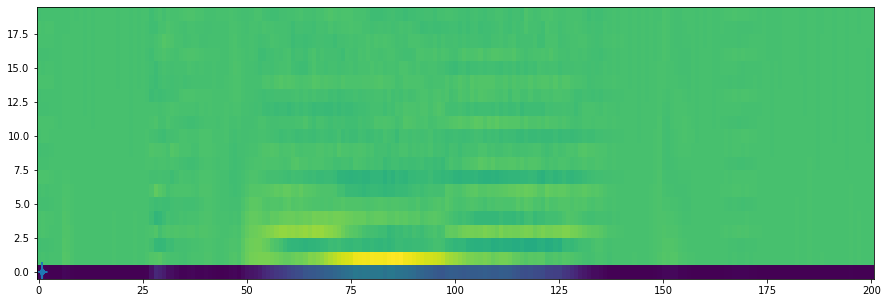

In [203]:
data = librosa.feature.mfcc(y=audio, sr=sr, n_fft=1024, hop_length=441, n_mfcc=20)
plt.figure(figsize=(15,5))
plt.plot(np.linspace(0, len(audio) / sr, num=len(audio)), audio)
plt.imshow(data, aspect='auto', origin='lower');